# Model Explainability 

This notebook aims at showing the model explainability for the solution.

This note book is divided into multiple sections:
1. Understand the error per hierarchy level
2. Understand the error over time
3. Understand the error using SHAPS

## 00. Set up

The set up steps consist of: 
1. Import the packages to be used. 
2. Load the model to analyze.

In [6]:
# Import required libraries
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)
from src.core.config_loader import ConfigLoader
from src.core.clients.bigquery import BigQueryClient
%matplotlib inline

bq_client = BigQueryClient()
config_loader = ConfigLoader()

INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines


In [ ]:
from src.core.models.xgboost import XgboostModel

model = XgboostModel().load_model(
    '/Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260131_133708_all/model_0.pickle'
)
type(model)

INFO:src.core.models.xgboost:Model loaded from /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260131_133708_all/model_0.pickle


src.core.models.xgboost.XgboostModel

## 0.1 Understanding the error per hierarchy level

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, median_absolute_error, mean_pinball_loss

def error_for_group(group):
    group["actuals"] = np.expm1(group[config_loader.target_col])
    group["benchmark"] = np.expm1(group[config_loader.benchmark_col])
    group["predictions"] = model.predict(group[model.features], True)

    # group["actuals"] = group[config_loader.target_col]
    # group["benchmark"] = group[config_loader.benchmark_col]
    # group["predictions"] = model.predict(group[model.features], False)

    return pd.Series({
        "pred_mae": mean_absolute_error(group["actuals"], group["predictions"]),
        "bench_mae": mean_absolute_error(group["actuals"], group["benchmark"]),
        "diff_mae": (
            mean_absolute_error(group["actuals"], group["predictions"])
            - mean_absolute_error(group["actuals"], group["benchmark"])
        ),
        "pred_rsme": root_mean_squared_error(group["actuals"], group["predictions"]),
        "bench_rsme": root_mean_squared_error(group["actuals"], group["benchmark"]),
        "diff_rsme": (
            root_mean_squared_error(group["actuals"], group["predictions"])
            - root_mean_squared_error(group["actuals"], group["benchmark"])
        ),
        "pred_mdae": median_absolute_error(group["actuals"], group["predictions"]),
        "bench_mdae": median_absolute_error(group["actuals"], group["benchmark"]),
        "diff_mdae": (
            median_absolute_error(group["actuals"], group["predictions"])
            - median_absolute_error(group["actuals"], group["benchmark"])
        ),
        "pred_mape": mean_absolute_percentage_error(group["actuals"], group["predictions"]),
        "bench_mape": mean_absolute_percentage_error(group["actuals"], group["benchmark"]),
        "diff_mape": (
            mean_absolute_percentage_error(group["actuals"], group["predictions"])
            - mean_absolute_percentage_error(group["actuals"], group["benchmark"])
        ),
        "pred_mdape": (abs(group["predictions"]-group["actuals"])/group["actuals"]).quantile(.50),
        "bench_mdape": (abs(group["benchmark"]-group["actuals"])/group["actuals"]).quantile(.50),
        "diff_mdape": ((abs(group["predictions"]-group["actuals"])/group["actuals"])).quantile(.50)
            - (abs(group["benchmark"]-group["actuals"])/group["actuals"]).quantile(.50)
        })

def retrieve_error_per_group(df, groupby_col):
    df = df.copy()

    return df.groupby(groupby_col).apply(lambda group: error_for_group(group))



In [9]:
metrics_df = pd.DataFrame(error_for_group(model.validation_df))
display(metrics_df)

,0
pred_mae,24.876386
bench_mae,31.388631
diff_mae,-6.512245
pred_rsme,42.672526
bench_rsme,58.396966
diff_rsme,-15.724440
pred_mdae,13.218983
bench_mdae,16.000000
diff_mdae,-2.781017
pred_mape,0.279108


In [1]:
(18-23)/23

-0.21739130434782608

In [10]:
metrics_df = pd.DataFrame(error_for_group(model.training_df))
display(metrics_df)

,0
pred_mae,25.515635
bench_mae,35.861509
diff_mae,-10.345874
pred_rsme,43.837673
bench_rsme,68.209784
diff_rsme,-24.372111
pred_mdae,13.284984
bench_mdae,18.000000
diff_mdae,-4.715016
pred_mape,0.263732


In [11]:
display(retrieve_error_per_group(model.validation_df, "ctx_cat_id"))
display(retrieve_error_per_group(model.training_df, "ctx_cat_id"))


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape,pred_mdape,bench_mdape,diff_mdape
ctx_cat_id,,,,,,,,,,,,,,,
FOODS,32.060908,41.207452,-9.146544,50.837927,72.814897,-21.976970,19.147552,23.0,-3.852448,0.250873,0.312996,-0.062123,0.182159,0.221106,-0.038947
HOBBIES,19.449589,24.321924,-4.872336,36.419179,47.257949,-10.838771,9.467495,12.0,-2.532505,0.376481,0.452021,-0.075540,0.219669,0.285714,-0.066045
HOUSEHOLD,19.533677,23.850630,-4.316953,34.607059,42.815097,-8.208038,10.288980,13.0,-2.711020,0.248745,0.310118,-0.061373,0.172380,0.218750,-0.046370


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape,pred_mdape,bench_mdape,diff_mdape
ctx_cat_id,,,,,,,,,,,,,,,
FOODS,35.347342,50.413960,-15.066618,55.724036,88.775900,-33.051864,20.857138,28.0,-7.142862,0.239674,0.320658,-0.080984,0.164298,0.224490,-0.060191
HOBBIES,17.160231,24.956874,-7.796643,32.105903,52.632139,-20.526236,8.476223,12.0,-3.523777,0.347093,0.444012,-0.096919,0.193107,0.277778,-0.084671
HOUSEHOLD,18.348293,24.322439,-5.974147,31.400966,41.845897,-10.444931,10.355358,14.0,-3.644642,0.241255,0.313994,-0.072739,0.162278,0.223301,-0.061023


## 02. Understand the error over time


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders

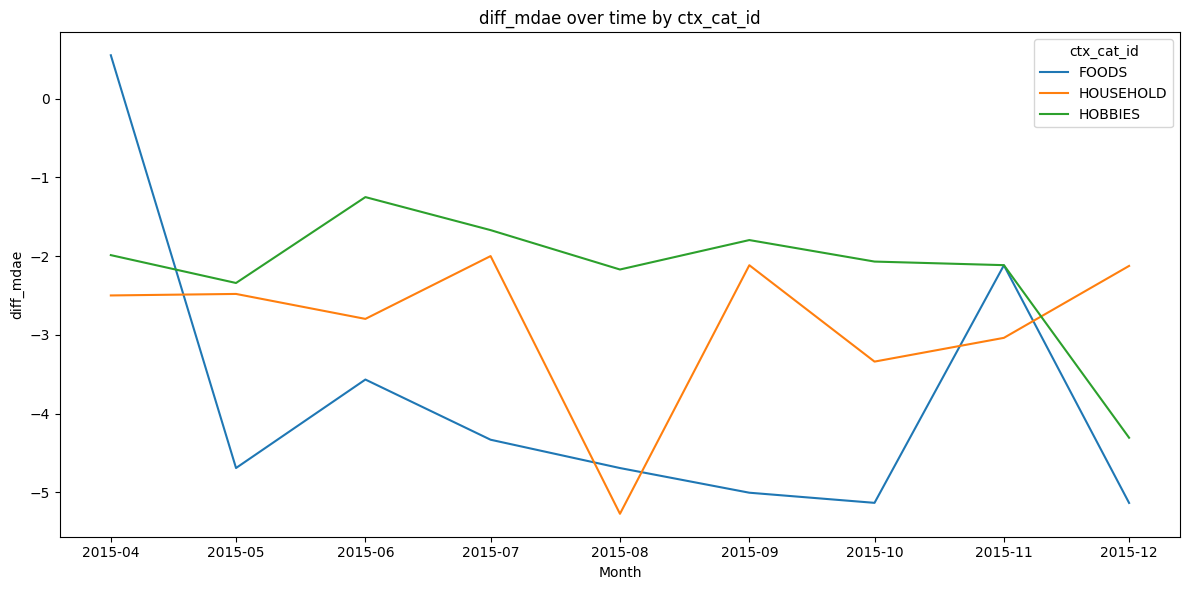

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders

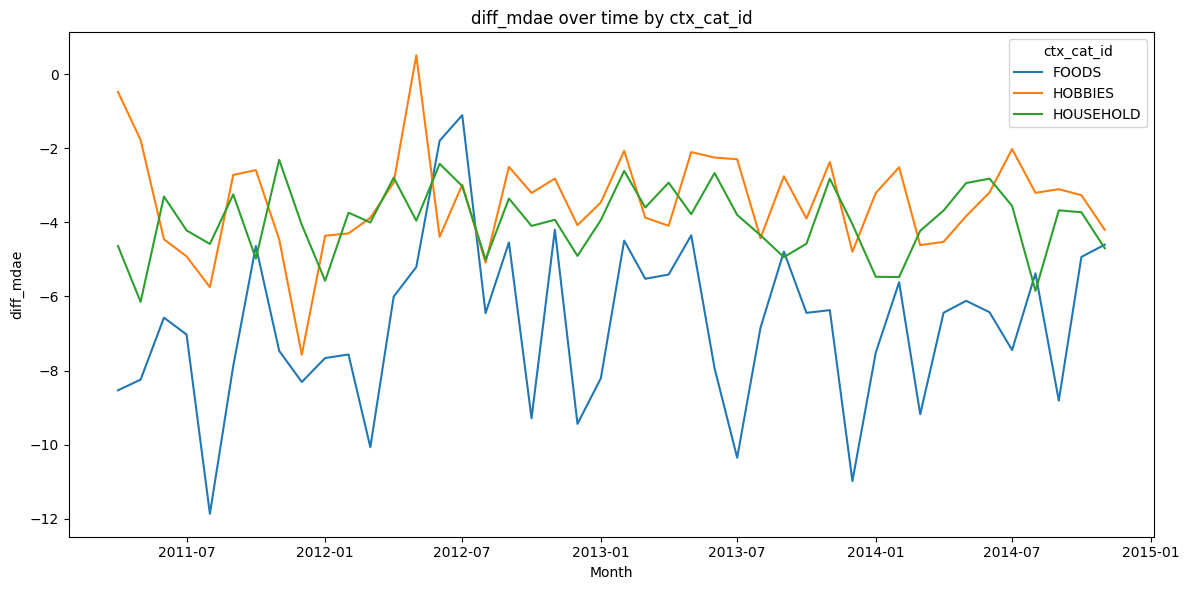

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_error_per_col(df, col_name):
    df = df.copy()
    plt.figure(figsize=(12, 6))
    for col in df[col_name].unique():
        error_over_time = retrieve_error_per_group(
            df[df[col_name]==col], 
            "ctx_date_month"
        )
        error_over_time["diff_mdae"].plot(label=str(col))
    plt.title(f"diff_mdae over time by {col_name}")
    plt.xlabel("Month")
    plt.ylabel("diff_mdae")
    plt.legend(title=col_name)
    plt.tight_layout()
    plt.show()
    
plot_error_per_col(model.validation_df, "ctx_cat_id")
plot_error_per_col(model.training_df, "ctx_cat_id")

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders

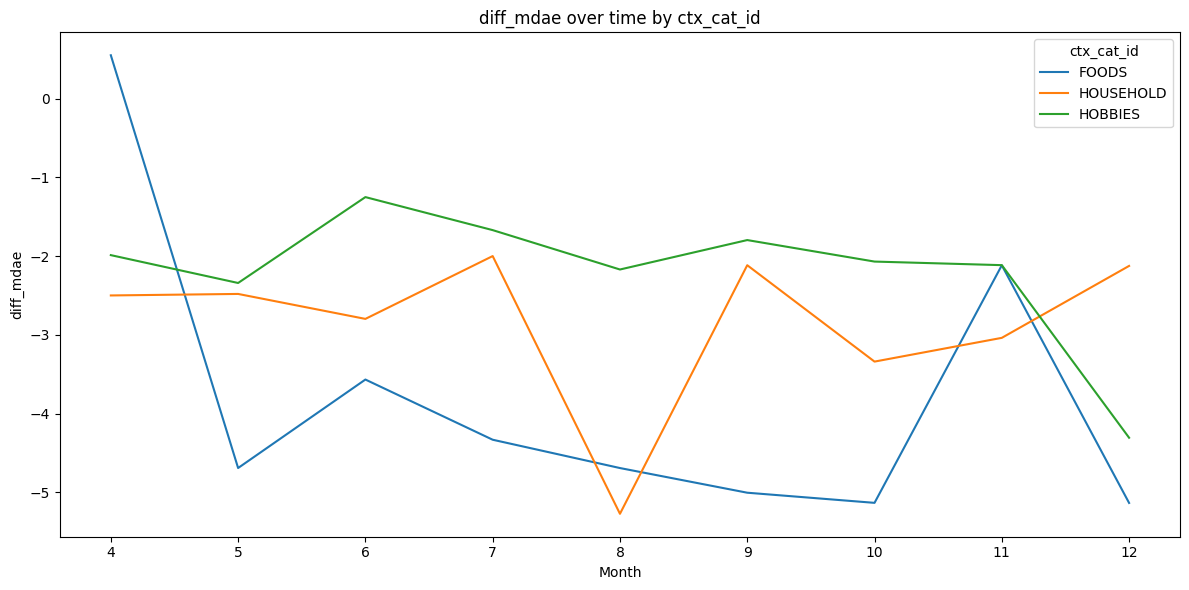

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders

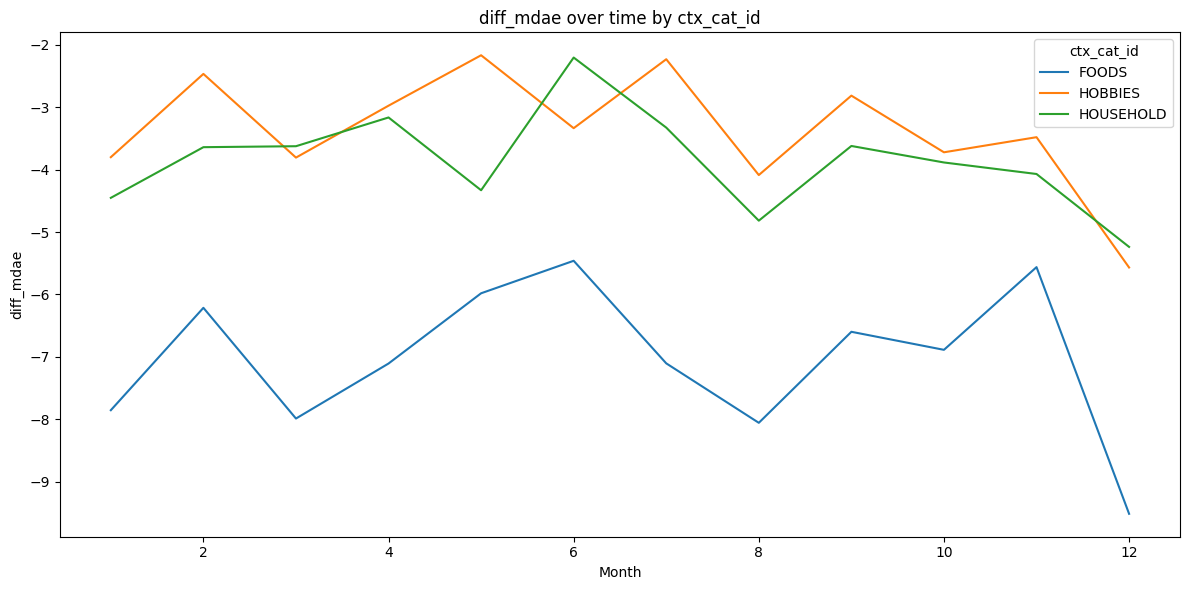

In [13]:
# Now lets look at it per month

import matplotlib.pyplot as plt
def plot_error_per_col(df, col_name):
    df = df.copy()
    df["ctx_month"] = pd.to_datetime(df['ctx_date_month']).dt.month
    plt.figure(figsize=(12, 6))
    for col in df[col_name].unique():
        error_over_time = retrieve_error_per_group(
            df[df[col_name]==col], 
            "ctx_month"
        )
        error_over_time["diff_mdae"].plot(label=str(col))
    plt.title(f"diff_mdae over time by {col_name}")
    plt.xlabel("Month")
    plt.ylabel("diff_mdae")
    plt.legend(title=col_name)
    plt.tight_layout()
    plt.show()
    
plot_error_per_col(model.validation_df, "ctx_cat_id")
plot_error_per_col(model.training_df, "ctx_cat_id")

# 04. Understand error per data completion

In [14]:
data_completion = model.training_df.groupby(["ctx_item_id"]).count()[["ctx_date_month"]].reset_index().rename(columns={"ctx_date_month": "data_completion"})

df = model.training_df.copy()
df = df.merge(data_completion, on =["ctx_item_id"], how="left")
df["completion_qs"] = pd.qcut(df["data_completion"], q=5)

In [15]:
display(retrieve_error_per_group(df, "completion_qs"))

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape,pred_mdape,bench_mdape,diff_mdape
completion_qs,,,,,,,,,,,,,,,
"(0.999, 19.0]",25.947373,39.713588,-13.766215,45.665058,84.597310,-38.932252,12.757793,18.0,-5.242207,0.308967,0.401750,-0.092783,0.186592,0.269231,-0.082639
"(19.0, 28.0]",27.389853,39.301816,-11.911963,48.122285,76.564354,-28.442069,13.433128,18.0,-4.566872,0.273082,0.364267,-0.091185,0.173355,0.244318,-0.070963
"(28.0, 35.0]",26.162266,36.110995,-9.948729,43.900617,64.010052,-20.109435,13.864738,18.0,-4.135262,0.261416,0.339352,-0.077937,0.170583,0.232558,-0.061975
"(35.0, 43.0]",22.910079,30.525101,-7.615022,40.602116,54.977265,-14.375150,11.985832,16.0,-4.014168,0.248910,0.327788,-0.078878,0.166519,0.228571,-0.062052
"(43.0, 44.0]",24.842443,32.693282,-7.850839,39.275020,51.685016,-12.409996,14.960028,20.0,-5.039972,0.215862,0.279906,-0.064044,0.148621,0.200000,-0.051379


# 05. Understand error per coefficient of variation

In [16]:
df = model.validation_df.copy()
df["coeffvar_qs"] = pd.qcut(df["fea_item_monthly_sales_roll_coeffvar_12_months"], q=5)

In [17]:
display(retrieve_error_per_group(df, "coeffvar_qs"))

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape,pred_mdape,bench_mdape,diff_mdape
coeffvar_qs,,,,,,,,,,,,,,,
"(0.534, 2.033]",25.442413,34.689570,-9.247156,47.100668,71.084734,-23.984066,11.247914,15.0,-3.752086,0.421808,0.529781,-0.107973,0.259596,0.357143,-0.097547
"(2.033, 2.566]",23.516024,30.711921,-7.195896,41.631643,59.501623,-17.869981,11.750635,15.0,-3.249365,0.296649,0.376968,-0.080319,0.209955,0.275862,-0.065907
"(2.566, 3.221]",22.730165,29.022627,-6.292462,38.590724,53.938676,-15.347952,11.992754,15.0,-3.007246,0.256208,0.317230,-0.061022,0.186907,0.230769,-0.043862
"(3.221, 4.249]",24.458177,29.604581,-5.146404,41.855203,51.381513,-9.526310,13.518864,16.0,-2.481136,0.237970,0.283376,-0.045406,0.171384,0.205745,-0.034361
"(4.249, 18.524]",28.235151,32.914459,-4.679308,43.725891,53.926847,-10.200956,18.048534,20.0,-1.951466,0.182906,0.212992,-0.030086,0.139832,0.153846,-0.014014


# 06. Understand item level arima scores

In [18]:
arima_scores = pd.read_csv('/Users/anapreciado/Desktop/porygon-demand-forecasting/src/notebooks/legacy_data_exploration/ts_attributes/autoarima_results_per_item.csv')

In [19]:
arima_scores.columns

Index(['Unnamed: 0', 'ctx_item_id', 'arima_orer', 'seasonal_order', 'aic',
       'arima_order_p', 'arima_order_d', 'arima_order_q', 'seasonal_order_p',
       'seasonal_order_d', 'seasonal_order_q', 'seasonal_order_m'],
      dtype='object')

In [20]:
df = model.training_df.copy()
df = df.merge(arima_scores, on = "ctx_item_id", how = "left")

In [21]:
display(df.groupby(['arima_order_d']).count())
display(retrieve_error_per_group(df, "arima_order_d"))

,ctx_item_id,ctx_date_month,ctx_cat_id,ctx_dept_id,ctx_store_id,tgt_monthly_sales_sum_3_next_months,tgt_benchmark,fea_item_monthly_sales_roll_avg_12_months,fea_item_monthly_sales_lag_1_months,fea_item_vs_dept_price_ratio_min,...,Unnamed: 0,arima_orer,seasonal_order,aic,arima_order_p,arima_order_q,seasonal_order_p,seasonal_order_d,seasonal_order_q,seasonal_order_m
arima_order_d,,,,,,,,,,,,,,,,,,,,,
0.0,30358,30358,30358,30358,30358,30358,30358,30358,30358,30358,...,30358,30358,30358,30358,30358,30358,30358,30358,30358,30358
1.0,19085,19085,19085,19085,19085,19085,19085,19085,19085,19085,...,19085,19085,19085,19085,19085,19085,19085,19085,19085,19085
2.0,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape,pred_mdape,bench_mdape,diff_mdape
arima_order_d,,,,,,,,,,,,,,,
0.0,27.118599,38.159826,-11.041227,46.381872,72.771618,-26.389746,14.614811,20.0,-5.385189,0.248957,0.330701,-0.081744,0.167347,0.228571,-0.061224
1.0,27.083215,37.930050,-10.846835,44.040200,67.822200,-23.782001,15.227188,21.0,-5.772812,0.220732,0.291430,-0.070699,0.151072,0.207792,-0.056720
2.0,63.579758,59.833333,3.746425,71.296555,71.958900,-0.662346,58.905182,51.5,7.405182,0.285466,0.236753,0.048712,0.160984,0.139134,0.021850


In [22]:
display(retrieve_error_per_group(df, "seasonal_order_q"))

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape,pred_mdape,bench_mdape,diff_mdape
seasonal_order_q,,,,,,,,,,,,,,,
0.0,27.222193,38.132556,-10.910364,45.602438,70.831479,-25.229041,14.921772,20.0,-5.078228,0.239160,0.316390,-0.077230,0.160944,0.219178,-0.058234
1.0,27.152571,38.741275,-11.588704,46.114621,73.696986,-27.582365,14.615074,20.0,-5.384926,0.233724,0.312135,-0.078411,0.160183,0.222222,-0.062039
2.0,22.072593,29.915888,-7.843295,34.305766,44.825492,-10.519726,14.451572,20.0,-5.548428,0.224154,0.302078,-0.077924,0.160425,0.225847,-0.065422


## 07. Understand error in slope

In [23]:
import numpy as np

cols = [
    "fea_item_monthly_sales_lag_1_months",
    "fea_item_monthly_sales_lag_2_months",
    "fea_item_monthly_sales_lag_3_months",
    "fea_item_monthly_sales_lag_4_months",
    "fea_item_monthly_sales_lag_5_months",
    "fea_item_monthly_sales_lag_6_months",
    "fea_item_monthly_sales_lag_7_months",
    "fea_item_monthly_sales_lag_8_months",
    "fea_item_monthly_sales_lag_9_months",
    "fea_item_monthly_sales_lag_10_months",
    "fea_item_monthly_sales_lag_11_months",
    "fea_item_monthly_sales_lag_12_months"
]

X = np.arange(len(cols))
Y = df[cols].values  # shape: (n_rows, 12)
N = len(cols)

sum_x = X.sum()
sum_x2 = (X**2).sum()

sum_y = Y.sum(axis=1)
sum_xy = (Y * X).sum(axis=1)

numerator = N * sum_xy - sum_x * sum_y
denominator = N * sum_x2 - sum_x**2

slopes = numerator / denominator
df["ts_slope"] = abs(slopes)

In [24]:
df = df[~df['ts_slope'].isna()]
df["ts_slope_qs"] = pd.qcut(df["ts_slope"], q=10)
display(retrieve_error_per_group(df, "ts_slope_qs"))

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))
/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_91139/3212933508.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(groupby_col).apply(lambda group: error_for_group(group))


,pred_mae,bench_mae,diff_mae,pred_rsme,bench_rsme,diff_rsme,pred_mdae,bench_mdae,diff_mdae,pred_mape,bench_mape,diff_mape,pred_mdape,bench_mdape,diff_mdape
ts_slope_qs,,,,,,,,,,,,,,,
"(-0.001, 0.112]",12.361043,17.533145,-5.172102,23.520045,34.663172,-11.143127,6.643883,10.0,-3.356117,0.271081,0.368096,-0.097015,0.178007,0.254054,-0.076047
"(0.112, 0.234]",12.650193,17.758746,-5.108553,21.956347,33.796772,-11.840426,7.125861,11.0,-3.874139,0.272041,0.372773,-0.100732,0.181369,0.263158,-0.081789
"(0.234, 0.378]",14.433924,19.962506,-5.528582,25.160364,33.705895,-8.545531,8.163752,12.0,-3.836248,0.264328,0.358752,-0.094424,0.173578,0.253809,-0.080230
"(0.378, 0.545]",15.658522,21.081758,-5.423236,27.377452,38.417135,-11.039682,9.076218,12.0,-2.923782,0.256129,0.329012,-0.072883,0.168026,0.225806,-0.057780
"(0.545, 0.773]",17.580226,23.729957,-6.149731,29.593571,40.536326,-10.942754,10.923082,15.0,-4.076918,0.248016,0.328205,-0.080189,0.165025,0.232143,-0.067118
"(0.773, 1.073]",20.169625,27.415660,-7.246035,32.967479,47.443136,-14.475657,12.681974,17.0,-4.318026,0.249646,0.318433,-0.068787,0.158477,0.216216,-0.057739
"(1.073, 1.528]",23.645488,32.819822,-9.174334,36.381483,57.143557,-20.762074,15.611504,20.0,-4.388496,0.238118,0.304225,-0.066107,0.157011,0.205882,-0.048871
"(1.528, 2.259]",29.316212,39.689140,-10.372928,43.729270,62.861508,-19.132238,19.648987,26.0,-6.351013,0.234437,0.299160,-0.064723,0.159129,0.208955,-0.049827
"(2.259, 3.983]",40.427829,55.214904,-14.787074,59.135299,84.892537,-25.757237,27.142891,36.0,-8.857109,0.256477,0.330751,-0.074274,0.161514,0.220559,-0.059045


## 08. Predictions Over Time

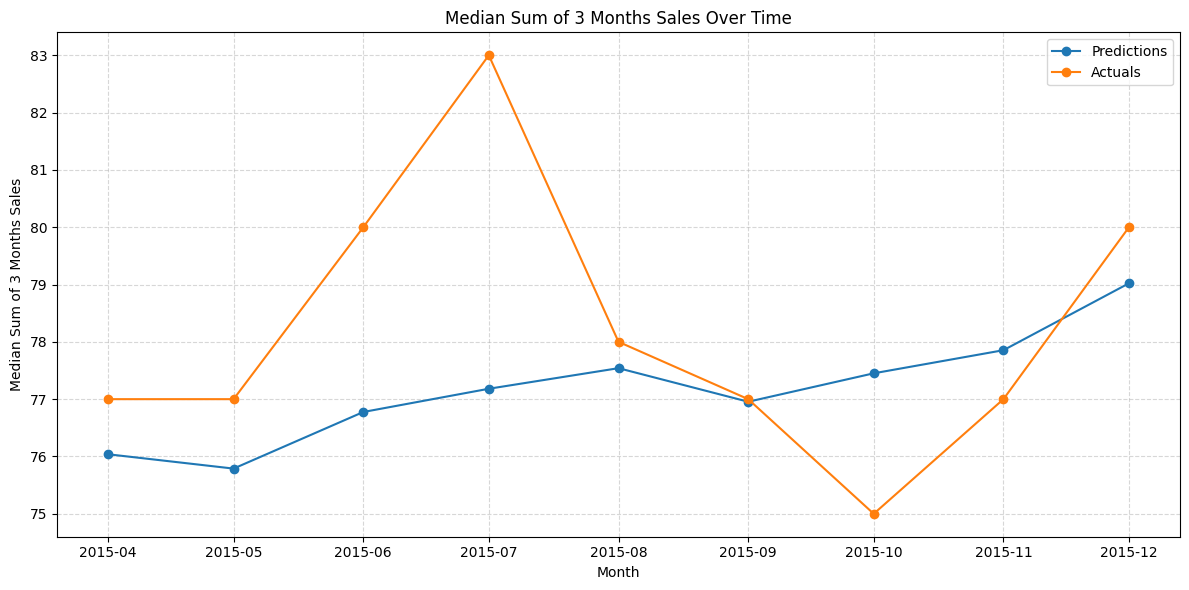

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot Meidan Error

train_mde_over_time = df.groupby(
    ["ctx_date_month"]
)[["predictions", "actuals"]].median()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(train_mde_over_time.index, train_mde_over_time['predictions'], marker='o', label='Predictions')
plt.plot(train_mde_over_time.index, train_mde_over_time['actuals'], marker='o', label='Actuals')
plt.title('Median Sum of 3 Months Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Median Sum of 3 Months Sales')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f"evolving_3months_sale_over_time.png", dpi=150)
plt.show()

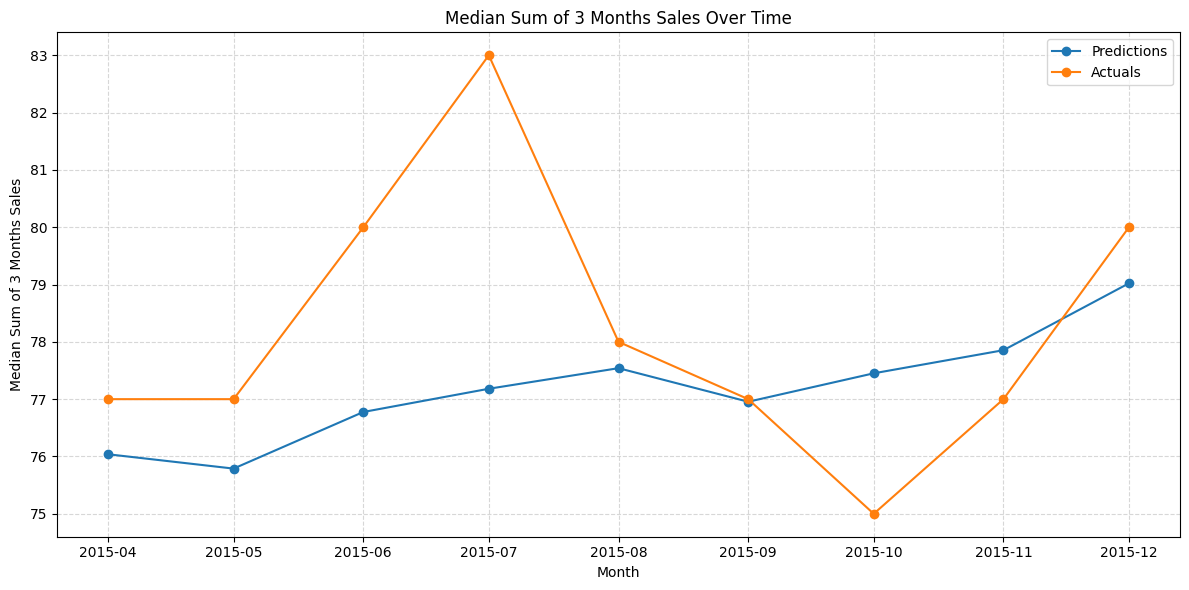

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot Meidan Error

df = model.validation_df.copy()
df["actuals"] = np.expm1(df[config_loader.target_col])
df["benchmark"] = np.expm1(df[config_loader.benchmark_col])
df["predictions"] = model.predict(df[model.features], True)

val_mde_over_time = df.groupby(
    ["ctx_date_month"]
)[["predictions", "actuals"]].median()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(val_mde_over_time.index, val_mde_over_time['predictions'], marker='o', label='Predictions')
plt.plot(val_mde_over_time.index, val_mde_over_time['actuals'], marker='o', label='Actuals')
plt.title('Median Sum of 3 Months Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Median Sum of 3 Months Sales')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f"evolving_3months_sale_over_time.png", dpi=150)
plt.show()

## 03. Define Function to Plot SHAPs

In [26]:
import xgboost as xgb

def get_shaps(df):
    df = df.copy()

    # Shap table for validation:
    shaps_dataset = df[model.features]
    matrix_observation = xgb.DMatrix(shaps_dataset)

    # Assuming your model is named 'model' and your features are in 'X_train'
    shap_values = model.model.get_booster().predict(matrix_observation, pred_contribs=True)

    # 1. SHAP values DataFrame (excluding bias)
    shap_df = pd.DataFrame(shap_values[:, :-1], columns=model.features, index=shaps_dataset.index)

    # Reshape to long format with separate columns for value and SHAP value
    feature_long = shaps_dataset.reset_index().melt(id_vars='index', value_vars=shaps_dataset.columns, var_name='feature', value_name='feature_value')
    shap_long = shap_df.reset_index().melt(id_vars='index', value_vars=shap_df.columns, var_name='feature', value_name='shap_value')
    # Merge the two long DataFrames on observation index and feature name
    merged_long_df = pd.merge(feature_long, shap_long, on=['index', 'feature'])

    # Rename 'index' to 'observation' for clarity
    merged_long_df.rename(columns={'index': 'observation'}, inplace=True)
    merged_long_df["abs_shap_value"] = abs(merged_long_df['shap_value'])

    df["predictions"] = model.predict(df[model.features])
    df["error"] = (df["predictions"] - df[config_loader.target_col])/df[config_loader.target_col]

    merged_long_df_preds = merged_long_df.merge(
        df[['predictions', 'error', 'ctx_date_month', 'ctx_dept_id', 'ctx_cat_id', 'ctx_item_id']],
        left_on='observation',
        right_index=True,
        how='left'
    )

    return merged_long_df_preds
